# 1. Backscatter - remote sensing in the ocean

Marine scientists use backscatter to understand the distribution of organisms in the ocean.

In this analysis, we are going to wrangle active acoustic data and plot the mean volume backscatter associated with fish with swim-bladders in relation to bathymetry (depth of the sea floor).

These acoustic data were collected from a research vessel that crossed the shelf break in the Mid-Atlantic Bight (NOAA cruise HB1103) and were preprocessed using the software, Echoview.

In [60]:
# Load the libraries
# .... YOUR CODE FOR TASK 1 ....
library(tidyverse)
library(lubridate)
library(geosphere)
library(gridExtra)

# Read in the depth data
bottom <- read_csv("datasets/bottom_line.csv", col_types = cols(Ping_date = col_datetime(format = "%m/%d/%Y")))

# Inspect the first six rows
head(bottom,6)

Ping_date,Ping_time,Ping_milliseconds,Latitude,Longitude,Position_status,Depth,Line_status,Ping_status,Altitude
<dttm>,<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-06-18,09:53:37,725,999.00000,999.00000,4,68.60377,1,0,-9.9e+37
2011-06-18,09:53:42,741,38.29771,-74.00185,3,68.60024,1,0,0.0e+00
2011-06-18,09:58:47,866,38.29429,-73.99677,1,68.78515,1,0,0.0e+00
2011-06-18,09:58:52,866,38.29424,-73.99666,1,68.77859,1,0,0.0e+00
2011-06-18,09:58:57,866,38.29418,-73.99653,1,68.37986,1,0,0.0e+00
2011-06-18,09:59:02,866,38.29411,-73.99641,1,68.37986,1,0,0.0e+00


# 2. What is the "shelf break"?

The "shelf break" is “The Big Drop-off!”. It's the underwater version of a cliff. In most marine ecosystems the shelf break is also a highly dynamic and productive area that provides homes and excellent buffets for many marine species. The smallest phytoplankton to the largest marine mammals, sharks, seabirds, tunas, and sea turtles - they all use this area at some point in their life cycles. And, we’re going to play with some active acoustic data from this fantastic region!

But first, let's clean up the bathymetry (depth) data and get it ready for plotting.



In [61]:
# Clean the bottom data
bottom_clean <- bottom %>%
   filter(Position_status == 1) %>%
    select(Ping_date,Ping_time,Latitude,Longitude,Depth)%>%
  mutate(DT = Ping_date + Ping_time,
       dist = c(0, distHaversine(cbind(Longitude[-n()], Latitude[-n()]),
                                 cbind(Longitude[ -1], Latitude[ -1]))),                         
       distalong = cumsum(dist),
       t_diff = c(NA, difftime(DT[ -1], DT[-n()], units = "secs")),
       m_per_sec = dist/t_diff)
  
# Inspect the first six rows
head(bottom_clean,6)

Ping_date,Ping_time,Latitude,Longitude,Depth,DT,dist,distalong,t_diff,m_per_sec
<dttm>,<time>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
2011-06-18,09:58:47,38.29429,-73.99677,68.78515,2011-06-18 09:58:47,0.00000,0.00000,NA,NA
2011-06-18,09:58:52,38.29424,-73.99666,68.77859,2011-06-18 09:58:52,11.47956,11.47956,5,2.295913
2011-06-18,09:58:57,38.29418,-73.99653,68.37986,2011-06-18 09:58:57,12.77948,24.25904,5,2.555895
2011-06-18,09:59:02,38.29411,-73.99641,68.37986,2011-06-18 09:59:02,13.24406,37.50310,5,2.648813
2011-06-18,09:59:07,38.29404,-73.99627,68.37986,2011-06-18 09:59:07,14.17050,51.67360,5,2.834099
2011-06-18,09:59:12,38.29396,-73.99612,68.38039,2011-06-18 09:59:12,15.34577,67.01937,5,3.069153


# 3. Where ever you go, there you are

Now that we have removed the bad data points and calculated the cumulative distance the ship traveled, let's plot the data to see if our calculation makes sense. A horizontal view of the ship's track will show us if the ship deviated from the track line or if there were any breaks in the data. A plot of the depth of the sea floor along the track line will show us the position of the shelf break. In a spatial analysis of the track line data, we would typically work in the packages sp and sf, but that's a topic all its own. For now, we'll create a couple of track line plots with the latitude, longitude, depth, and distance along the track line.

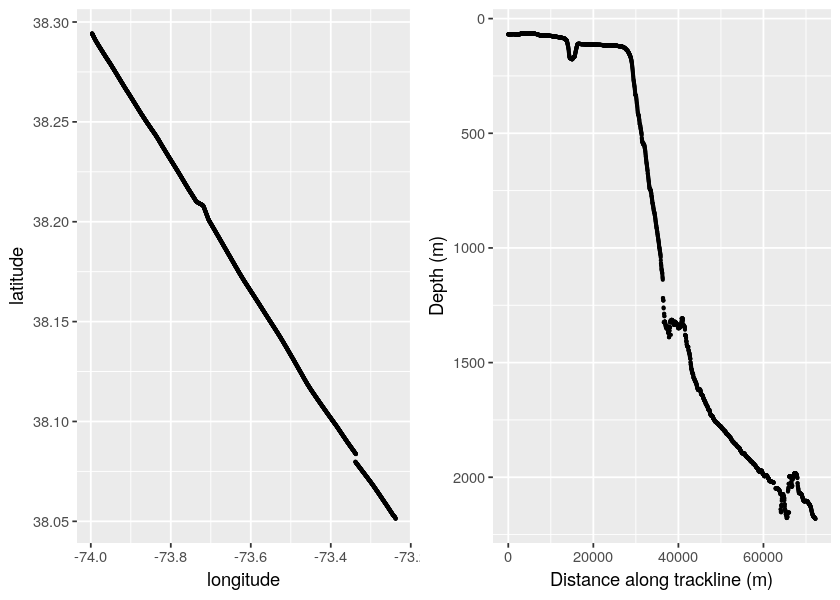

In [52]:
# Reduce the size of the plots
options(repr.plot.width = 7, repr.plot.height = 5)

# Plot the ship's track
p_LonLat  <- ggplot(bottom_clean, aes( x = Longitude, y = Latitude)) +
  geom_point( size = 0.5 )+
  labs( x = "longitude", y = "latitude")
# Plot the depth of the sea floor along the ship's track
p_bthy  <-  ggplot(bottom_clean, aes( x = distalong, y = Depth )) +
  geom_point( size = 0.5)+ scale_y_reverse()+
  labs(x = "Distance along trackline (m)", y = "Depth (m)")

# Arrange the plots side by side for easier viewing
grid.arrange(p_LonLat, p_bthy, nrow = 1)

# 4. What's the difference?

It looks like the straight track line isn't so straight. This happens quite often with data collected in this area. There is a lot of fishing gear in the shelf break region of the Mid-Atlantic Bight, and sometimes the ship must divert from the track line to avoid it. It is also possible that the GPS signal was lost for a few minutes. Let's find out what the difference is between the straight-line length of the track line (start point to endpoint) and the cumulative distance the ship traveled.

Calculating the difference between the cumulative meters traveled and the straight-line distance of the track line is a common task - a perfect time to create a function to use on other track line data files!

In [38]:
# Create the function
distance_diff <- function(bottom_data){
  cumulative_dist <- last(bottom_data$distalong)
  start <- cbind(first(bottom_data$Longitude), first(bottom_data$Latitude))
  end <- cbind(last(bottom_data$Longitude), last(bottom_data$Latitude))
  straight_line_dist <-  distHaversine(start, end)
  return(round(cumulative_dist - straight_line_dist, 1))
}

# Run distance_diff on the cleaned bottom data
distance_diff(bottom_clean)

[1] 513.3

# 5. Here fishy, fishy, fishy...

In the grand scheme of track line diversions, a 513-meter difference isn't too bad. This difference could play a larger or small role in the data analysis depending on the ecological question being asked. For now, we'll keep it in mind as we load, clean, and plot out the acoustic data.

Volume backscatter is the integration of all the returned echoes within the sampling volume. It's a measure of the relative density of organisms. In this case, because we preprocessed the data in Echoview to look for fish-like scattering, our final plot of the volume backscatter data, Sv_mean, will give us an indication of the distribution of fish along the track line.

Will there be sections of the track line with higher/lower densities if fish? Let's find out!

In [53]:
# Read in the acoustic data
acoustic <- read_csv("datasets/acoustic_LgSBF.csv", col_types = cols(Date_M = col_datetime(format = "%Y%m%d"))) %>% 
filter(Lon_M != 999.0) 
# Glimpse the data
glimpse(acoustic)

Observations: 724
Variables: 78
$ Process_ID                           <dbl> 20216, 20216, 20216, 20216, 2021…
$ Interval                             <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…
$ Layer                                <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Sv_mean                              <dbl> -67.97805, -67.65053, -66.65866,…
$ NASC                                 <dbl> 365.6001, 429.4046, 539.5769, 37…
$ Sv_max                               <dbl> -53.93325, -54.51390, -51.31861,…
$ Sv_min                               <dbl> -88.67275, -87.36100, -88.99463,…
$ Sv_noise                             <dbl> -967.8684, -967.6432, -967.6233,…
$ NASC_noise                           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Height_mean                          <dbl> 53.25000, 58.00000, 58.00000, 58…
$ Depth_mean                           <dbl> 39.04617, 39.00000, 39.00000, 39…
$ Good_samples                         <dbl> 639, 522, 464, 464, 406, 464, 40…
$ Layer_depth_min   

# 6. That's a lot of variables!

Wow! 724 observations of 78 variables! This is the full data export from Echoview, but remember, we’re only interested in the volume backscatter data, Sv_mean, and the few other variables needed to plot the data.

These backscatter data were integrated into grid cells that are 200 meters along the ship’s path (numbered in the variable, Interval), by 250 meters deep, (numbered in the variable, Layer), making a coordinate system referenced to the ship’s path and depth. We are going to explore the first depth layer.

In [54]:
# Create a list of variables to keep
vars_keep <- c("Interval", "Layer", "Sv_mean", "Frequency", 
               "Date_M", "Time_S", "Time_E", "Lat_M", "Lon_M")

# Select, rename, filter, mutate, and arrange the data 
Sv_sbf_layer1 <- acoustic %>%
    select(one_of(vars_keep)) %>% 
    rename(sp_interval = Interval) %>%
    filter(Layer == 1)  %>% 
    mutate(DT_S = Date_M + Time_S,
         DT_E = Date_M + Time_E)  %>% 
    arrange(DT_S) 

# Glimpse the cleaned acoustic data
glimpse(Sv_sbf_layer1)

Observations: 362
Variables: 11
$ sp_interval <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ Layer       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ Sv_mean     <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02423, -6…
$ Frequency   <dbl> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 3…
$ Date_M      <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-…
$ Time_S      <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52, 10:02:…
$ Time_E      <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22, 10:03:…
$ Lat_M       <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, 38.2900…
$ Lon_M       <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98776, -7…
$ DT_S        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06-18 10:…
$ DT_E        <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06-18 10:…


# 7. A little more wrangling

Great! All this is coming together nicely. In bottom_clean we have depth, distance along the track line, and timestamps. We now also have an almost clean acoustic dataset, Sv_sbf_layer1, with timestamps but no distance along the track line, and no depth information (we'll get to that in a minute). Also, Echoview uses -999.0 to indicate NAs. We need to fix that or our plot of backscatter will look a little wonky. 

In [55]:
# More data wrangling...
Sv_sbf <- Sv_sbf_layer1 %>% 
  mutate(dist_M = c(0, distHaversine(cbind(Lon_M[-n()], Lat_M[-n()]),       
                          cbind(Lon_M[  -1], Lat_M[  -1]))),
       distalong = cumsum(dist_M)) %>%
  na_if(-999.0) %>% 
  mutate(tm_interval = interval(DT_S, DT_E))

# Glimpse the data
glimpse(Sv_sbf)

Observations: 362
Variables: 14
$ sp_interval <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ Layer       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ Sv_mean     <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02423, -6…
$ Frequency   <dbl> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 3…
$ Date_M      <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-…
$ Time_S      <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52, 10:02:…
$ Time_E      <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22, 10:03:…
$ Lat_M       <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, 38.2900…
$ Lon_M       <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98776, -7…
$ DT_S        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06-18 10:…
$ DT_E        <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06-18 10:…
$ dist_M      <dbl> 0.0000, 211.7871, 192.3324, 204.8778, 209.1278, 183.3635,…
$ distalong   <dbl> 

# 8. Can't go spatial? Go temporal

There is no depth information in the acoustic file. Well, that's not exactly true. One of those 78 variables was a mean depth, but it was an average of an average, and it was not as accurate as the depth data we have in bottom_clean.

You might have also noticed that the two data sets have different spatial resolutions. How can we pull the depth data out of bottom_clean and join it with the acoustic data? There are a few different spatial ways to do this, but because we are not working in the spatial packages, we'll write a function to figure out which data points from bottom_clean fall within the time interval, tm_interval, we just created

In [62]:
# Function: assign sp_interval to bottom points that fall within tm_interval
get_Interval_by_time <- function(bottom_data){
  res <- Sv_sbf$sp_interval[bottom_data %within% Sv_sbf$tm_interval]
  if(length(res)==0) return(NA)         
  return(res)
}

# Map the track line interval value to bottom_clean
bottom_clean_int <- bottom_clean  %>% 
    mutate(trkln_interval = map_dbl(DT, get_Interval_by_time))

# Inspect the first 15 rows
head(bottom_clean_int,15)

Ping_date,Ping_time,Latitude,Longitude,Depth,DT,dist,distalong,t_diff,m_per_sec,trkln_interval
<dttm>,<time>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-06-18,09:58:47,38.29429,-73.99677,68.78515,2011-06-18 09:58:47,0.00000,0.00000,NA,NA,4
2011-06-18,09:58:52,38.29424,-73.99666,68.77859,2011-06-18 09:58:52,11.47956,11.47956,5,2.295913,4
2011-06-18,09:58:57,38.29418,-73.99653,68.37986,2011-06-18 09:58:57,12.77948,24.25904,5,2.555895,4
2011-06-18,09:59:02,38.29411,-73.99641,68.37986,2011-06-18 09:59:02,13.24406,37.50310,5,2.648813,4
2011-06-18,09:59:07,38.29404,-73.99627,68.37986,2011-06-18 09:59:07,14.17050,51.67360,5,2.834099,4
2011-06-18,09:59:12,38.29396,-73.99612,68.38039,2011-06-18 09:59:12,15.34577,67.01937,5,3.069153,4
2011-06-18,09:59:17,38.29390,-73.99597,68.38039,2011-06-18 09:59:17,15.09648,82.11585,5,3.019296,4
2011-06-18,09:59:22,38.29383,-73.99582,68.37777,2011-06-18 09:59:22,15.72843,97.84428,5,3.145686,4
2011-06-18,09:59:27,38.29375,-73.99564,68.37777,2011-06-18 09:59:27,18.05774,115.90203,5,3.611549,4


# 9. Depth of an Interval

Now that we have spatial track line intervals from the acoustic data assigned to each data point in bottom_clean_int, we can group the bottom data by the interval and calculate the mean depth for each trkln_interval along the track line.

In [57]:
# Group bottom_clean and calculate the mean depth
bottom_intervals <- bottom_clean_int %>%
    group_by(trkln_interval) %>%
    summarize(depth_mean = mean(Depth)) %>%
    ungroup()

# Inspect the first six rows of bottom_intervals
head(bottom_intervals,6)

trkln_interval,depth_mean
<dbl>,<dbl>
4,68.43658
5,68.25401
6,68.22956
7,68.10563
8,68.14753
9,67.74444


# 10. Acoustic data, meet Depth data

We're almost ready to plot Sv_mean in relation to the bathymetry (depth) and find out where the high and low densities of fishes are along the track line.

But first, the two datasets need to be joined. Unfortunately, at the time of writing, the temporal intervals created in lubridate do not play well with joins. We'll have to remove them for the join to work. Also, remember that we're only looking at the first depth layer (0 to 250 m). Because we do not want to insinuate that we're plotting data integrated over the entire water column, we will replace depths greater than 250 m with 250.

In [58]:
# Join the bottom intervals data to the acoustic data
data_sbf_full <- Sv_sbf %>%
  select(-tm_interval) %>%
  left_join(bottom_intervals, by = c("sp_interval" = "trkln_interval")) %>% 
  mutate(depth_plot = ifelse(depth_mean >= 250, 250, depth_mean))

# Glimpse the data 
glimpse(data_sbf_full)

Observations: 362
Variables: 15
$ sp_interval <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ Layer       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ Sv_mean     <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02423, -6…
$ Frequency   <dbl> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 3…
$ Date_M      <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-…
$ Time_S      <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52, 10:02:…
$ Time_E      <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22, 10:03:…
$ Lat_M       <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, 38.2900…
$ Lon_M       <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98776, -7…
$ DT_S        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06-18 10:…
$ DT_E        <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06-18 10:…
$ dist_M      <dbl> 0.0000, 211.7871, 192.3324, 204.8778, 209.1278, 183.3635,…
$ distalong   <dbl> 

# 11. Putting it all together

Woohoo! This has been a lot of data wrangling, but we're almost done. It's time to plot the mean volume backscatter in relation to the bathymetry (depth) along the track line. Because our y-axes are on two different scales, we'll create two plots and use a function from grid.arrange() again to put them in one figure.

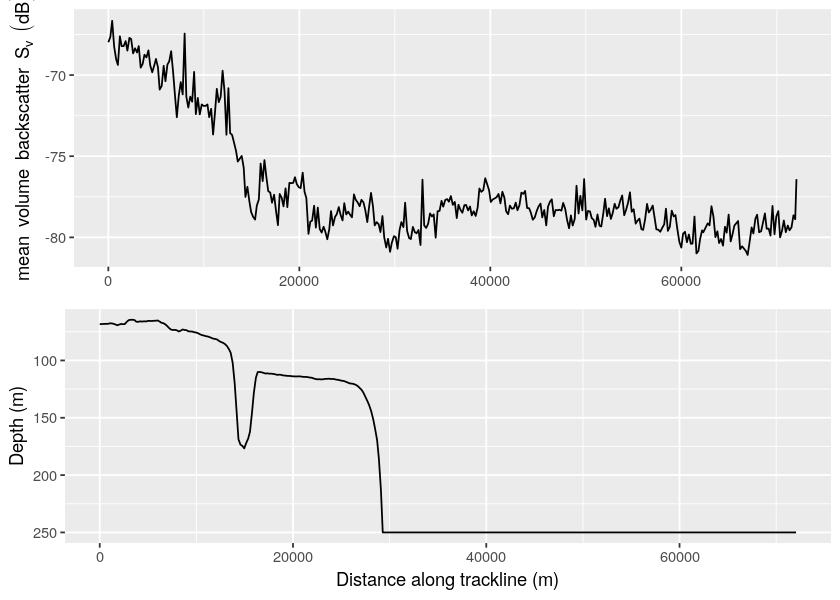

In [59]:
# Top panel - assign the Sv plot
Sv_mean_plot <- ggplot(data_sbf_full, aes( x = distalong, y = Sv_mean)) +
  geom_line( size = 0.5) +
  labs(y=expression(mean~volume~backscatter~S[v]~(dB))) +
  theme(axis.title.x=element_blank())

# Bottom panel - assign the bathymetry plot
bthy <- ggplot(data_sbf_full, aes( x = distalong , y = depth_plot )) +
  geom_line(size = 0.5) +
  scale_y_reverse()+
  labs(x = "Distance along trackline (m)", y = "Depth (m)")

# Display the two panels in one figure
grid.arrange(Sv_mean_plot, bthy)

# 12. So, where are the fishes?

If we assume that all the backscatter energy is only from fishes with swim bladders, and greater backscatter indicates higher densities of fish, most of the fish on this track line are on the Shelf.